In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
df = pd.read_csv('data/creditcard.csv')

In [82]:
df['Class'].value_counts()


Class
0    284315
1       492
Name: count, dtype: int64

In [83]:
(492 / 284807) * 100

0.1727485630620034

In [84]:
# Sum the 'Value' column where 'Category' is 'A'
df.loc[df['Class'] == 1, 'Amount'].sum()

np.float64(60127.97)

In [85]:
# Descriptive statistics for numerical columns
print(df['Amount'].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


In [86]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [87]:
print(df.iloc[:, 1:-2].describe().max(axis=1))
print(df.iloc[:, 1:-2].describe().min(axis=1))

count    2.848070e+05
mean     4.866699e-15
std      1.958696e+00
min     -2.604551e+00
25%     -5.295979e-02
50%      1.798463e-01
75%      1.315642e+00
max      1.205895e+02
dtype: float64
count    2.848070e+05
mean    -2.414189e-15
std      3.300833e-01
min     -1.137433e+02
25%     -9.203734e-01
50%     -2.741871e-01
75%      7.827995e-02
max      2.454930e+00
dtype: float64


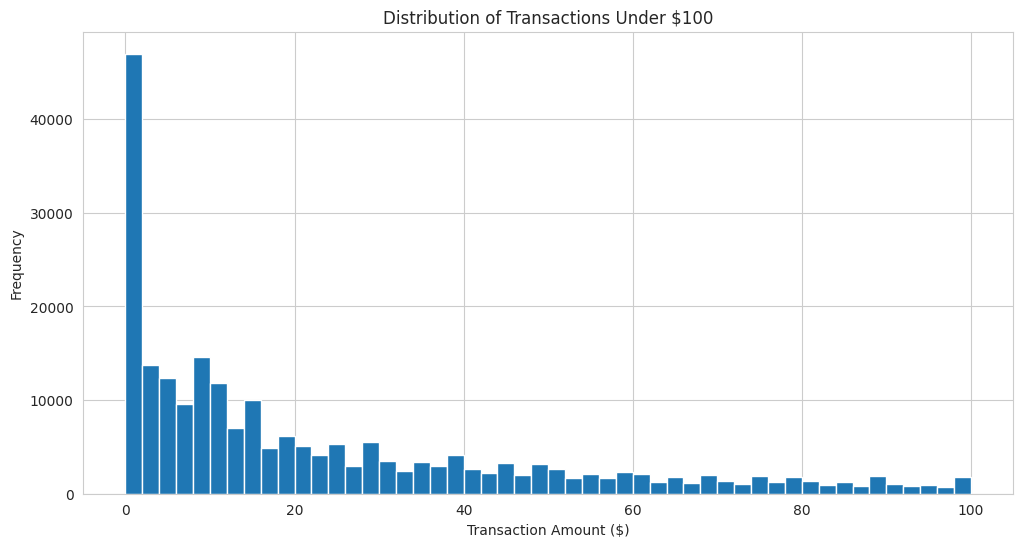

In [91]:
# visual grid
sns.set_style('whitegrid')
# under 100
df_under_100 = df[df['Amount'] < 100]
df_under_100['Amount'].plot(
    kind='hist',
    bins=50,
    title='Distribution of Transactions Under $100',
    figsize=(12, 6) # Making the plot bigger
)
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.show()


In [89]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

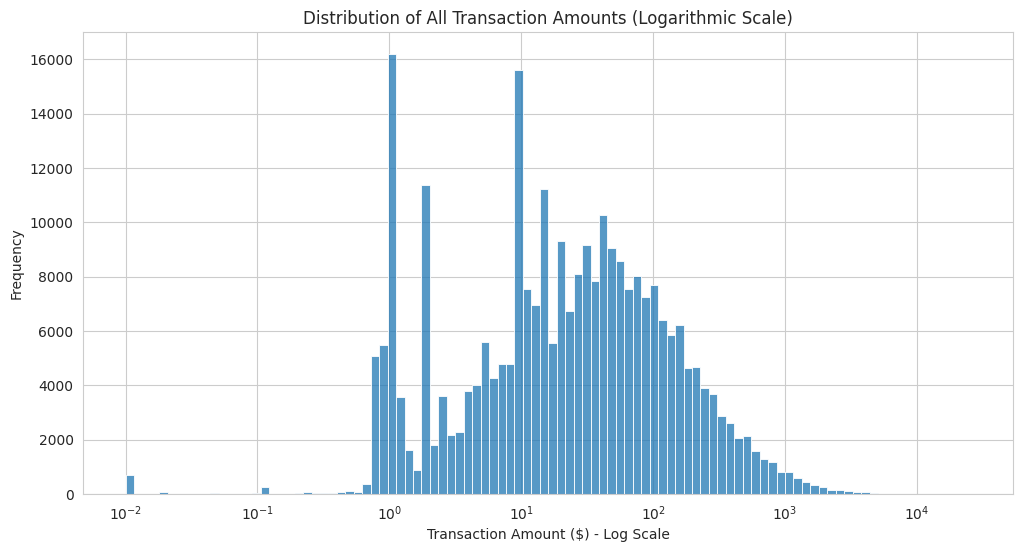

In [94]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Amount', bins=100, log_scale=True)

sns.histplot()
plt.title('Distribution of All Transaction Amounts (Logarithmic Scale)')
plt.xlabel('Transaction Amount ($) - Log Scale')
plt.ylabel('Frequency')
plt.show()
